# Swissroads Project: 03 - Knn classifier  

## General presentation
This is the first notebook of the Swissroad classification project. The aim of this project is to construct several classifiers to identify vehicles photographied in the streets around the Swiss School: EPFL. The project will be split into 9 jupyter notebook, each performing a specific task.
Our dataset comprises color photographies of 6 different types of vehicles: 
* Bikes
* Cars 
* Motorcycles
* Trucks 
* Vans 
* Others (for example, buses, scooters, etc.) 
Our data is already split into a train, validation and test set, with respectively: 280, 139 and 50 images of sizes 250x250. 
This is a relatively small dataset. When state of the art models trained for similar tasks on larger datasets are already documented and available, a beneficial option is to use one of these pre-trained model on our own dataset, either for classification purposes directly, or as a way of extracting features from the deep layers to inject these features in other machine learning models. This option is beneficial as it allows us to benefit from information obtained on a very large dataset and allows us to save time, as training complex convolutional networks is computationally expensive and can be very time consuming especially on a personal computer. 

For this project, we will use the Inception_v3 model available on the tensorflow hub to extract the 2048 most important features and use them in different classifiers: 
* A k-nearest neighbors classifiers
* A simple decision tree
* A logistic regression model
* Non linear classifiers such as Random Forest and SVMs 
* A dense network

Finally, we will also attempt to achieve the same level of accuracy by training our own convolutional network from scratch on our specific dataset.

## Aim of this notebook 

In this jupyter notebook, we will work with the set of high-level features that have been extracted thanks to the Inception_v3 ConvNet on the tensorflow hub, to train a knn classifier on our data. 
We will train our data on the train set, use the validation set to tune our hyperparameters and finally, evaluate the performance of our model with the test set. 

In [1]:
# loading libraries

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


In [2]:
# loading data
# Load data
with np.load('data/train.npz', allow_pickle=False) as npz_file:
    X_tr = npz_file['features']
    y_tr = npz_file['targets']
    names_tr = npz_file['names']
    
with np.load('data/valid.npz', allow_pickle=False) as npz_file:
    X_val = npz_file['features']
    y_val = npz_file['targets']
    names_val = npz_file['names']
    
with np.load('data/test.npz', allow_pickle=False) as npz_file:
    X_te = npz_file['features']
    y_te = npz_file['targets']
    names_te = npz_file['names']
    

In [3]:
print('X_train:', X_tr.shape, X_tr.dtype)
print('y_train:', y_tr.shape, y_tr.dtype)

print('X_validation:', X_val.shape, X_val.dtype)
print('y_validation:', y_val.shape, y_val.dtype)

print('X_test:', X_te.shape, X_te.dtype)
print('y_test:', y_te.shape, y_te.dtype)

X_train: (280, 2048) float32
y_train: (280,) <U10
X_validation: (139, 2048) float32
y_validation: (139,) <U10
X_test: (50, 2048) float32
y_test: (50,) <U10


As a first step, we perform a classification without fine tuning. 

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Create a k-NN classifier with default values
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Fit to train data
pipe.fit(X_tr, y_tr)

# Evaluate on test set
accuracy = pipe.score(X_val, y_val)
print('Accuracy without fine tuning: {:.3f}'.format(accuracy))

Accuracy without fine tuning: 0.914


The accuracy we have on the validation set without fine tuning is 91.4%, which is already pretty high. We will try fine tuning the model to try to increase this further. 
For this model, we will try to play around with: 
* the number of neighbors
* the weights function: wether all k neighbors have the same weighs or if they contribute more or less according to their distance to the point 
* the distance type: the metrics used to compute the distance: Manhattan or Euclidian

In [5]:
#Grid Search

from sklearn.model_selection import ParameterGrid

# Define a set of reasonable values
k_values = np.arange(1, 21) # 1, 2, 3, .., 20
weights_functions = ['uniform', 'distance']
distance_types = [1, 2] # L1, L2 distances

# Define a grid of values
grid = ParameterGrid({
    'knn__n_neighbors': k_values,
    'knn__weights': weights_functions,
    'knn__p': distance_types
})


In [6]:
# Create k-NN classifier
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Save accuracy on test set
test_scores = []

for params_dict in grid:
    # Set parameters
    pipe.set_params(**params_dict)

    # Fit a k-NN classifier
    pipe.fit(X_tr, y_tr)
    
    # Save accuracy on training set
    params_dict['tr_accuracy'] = pipe.score(X_tr, y_tr)

    # Save accuracy on validation set
    params_dict['val_accuracy'] = pipe.score(X_val, y_val)

    # Save result
    test_scores.append(params_dict)

In [7]:
# Create DataFrame with test scores
scores_df = pd.DataFrame(test_scores)

best_params = scores_df.iloc[scores_df['val_accuracy'].idxmax(), :]

# Top five scores
scores_df.sort_values(by='val_accuracy', ascending=False).head()

,knn__n_neighbors,knn__p,knn__weights,tr_accuracy,val_accuracy
10,3,2,uniform,0.957143,0.928058
20,6,1,uniform,0.928571,0.928058
21,6,1,distance,1.000000,0.928058
29,8,1,distance,1.000000,0.920863
16,5,1,uniform,0.935714,0.920863


At the end of the grid search, we can see that the best accuracy we achieve on the validation set is 92.8%, with either 3 or 6 neighbors with a uniform weigh for all of them, or 6 neighbors with a Manhatan distance used to weigh the k nearest neighbors. Using the best parameters, we fit the classifier a last time using the training and validation set together and compute the accuracy on the test set. 

In [8]:
# Evaluate on the test set

# Evaluate on test set

pipe_final = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors = best_params['knn__n_neighbors'], p = best_params['knn__p'], weights = best_params['knn__weights']))
])

pipe_final.fit(np.vstack((X_tr, X_val)), np.concatenate((y_tr, y_val)))
accuracy = pipe_final.score(X_te, y_te)
print('Accuracy after fine tuning: {:.3f}'.format(accuracy))

Accuracy after fine tuning: 0.960


The accuracy of our fine tuned knn classifier is the 96%. 

Finally, to demonstrate the good performance of our classifier, let's  display the 10 nearest neighbors in the training set of an imaged randomly picked in the test set: 

In [9]:
# display 10 nearest neighbors
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors = best_params['knn__n_neighbors'], p = best_params['knn__p'])#, metric_params = {weights : best_params['knn__weights']})
neigh.fit(np.vstack((X_tr, X_val)), np.concatenate((y_tr, y_val)))

NearestNeighbors(n_neighbors=3)

In [10]:
img_test = X_te[35,:].reshape(1, -1)

In [11]:
distances, indices = neigh.kneighbors(img_test, n_neighbors=10)

In [12]:
indices

array([[222, 377, 387, 205, 375, 221, 374, 225, 191, 204]], dtype=int64)

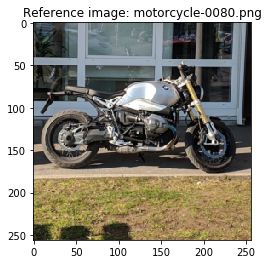

In [13]:
#load raw data
import PIL.Image as Image
%matplotlib inline
import matplotlib.pyplot as plt


# Load image
ref_image = names_te[35]+'.png'
ref_image_folder = y_te[35]
all_neighs = [x + '.png' for x in np.concatenate((names_tr,names_val))[indices].flatten().tolist()]
all_folders_neighs = np.concatenate((y_tr,y_val))[indices].flatten().tolist()
my_path = ["swissroads/train" if x < 280 else "swissroads/valid" for x in indices.flatten().tolist()]

#img = Image.open('swissroads/train/bike/bike-0001.png')
ref = Image.open(os.path.join("swissroads/test", ref_image_folder,ref_image))
plt.title('Reference image: {}'.format(ref_image))
plt.imshow(ref)
plt.show()

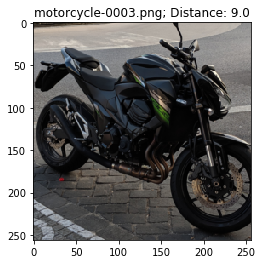

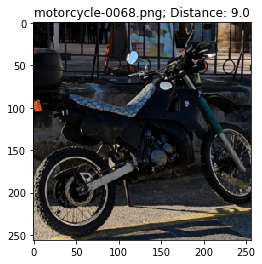

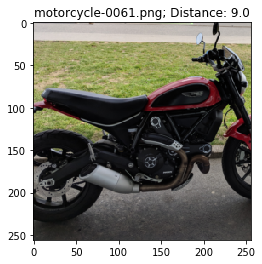

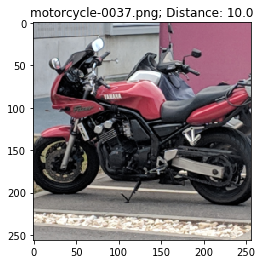

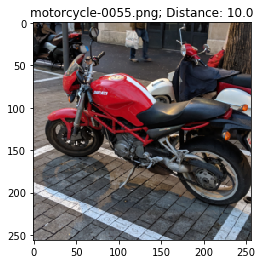

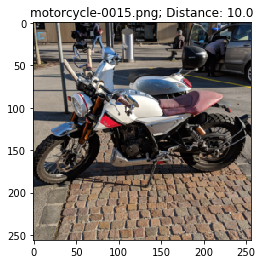

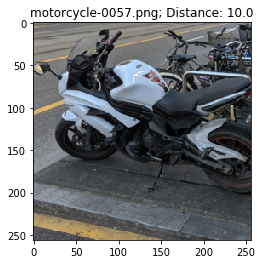

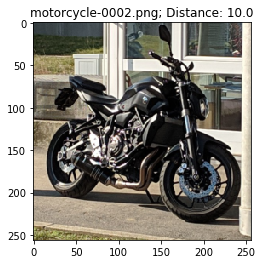

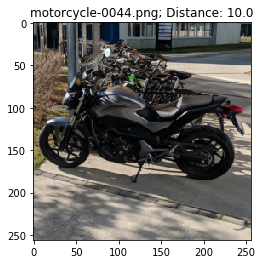

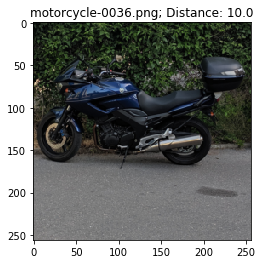

In [14]:
pos = 0
for  path, folder, file, dist  in zip(my_path, all_folders_neighs, all_neighs, distances.flatten().tolist()): 
    pos +=1   
    img =Image.open(os.path.join(path, folder,file))
    # Plot image with pyplot
    plt.imshow(img)
    plt.title('{}; Distance: {}'.format(file,round(dist,0)))
    plt.show()

As we can see, the reference image was a motorcycle image and so are all of its neighbors. 

Finally, we save the final test accuracy to compare with all the others methods.

In [15]:
np.savez('results/01_knn.npz', test_accuracy=accuracy)